# Evaluation notebook

Metrics on trace and variant level

1. Fitness 
- mean + std over all pm x cc x k, mean over the models, weighted by number of traces in cluster
- [x] Calculation and plot

2. Precision
- [x] Calculation From pm4py, with the last model from the clustering
- [x] plot

3. Cluster size table (?) too large
- [x] Calculation done, export to latex
- [x] export to latex

4. Execution times table
- [x] Calculation done, export to latex
- [ ] plot? Table? Low Priority

5. Convergence after x iterations
- [x] Improve Plot

6. Variant distribution: how many activities, traces, ... per variant?
- [ ] How many traces per variant
- [ ] How many different activities per trace
- [ ] The for each cluster: what is the min trace length and the max trace length?


Most importantly for each dataset:

- Check how many n_v variants per event log, i.e. how many of them are the largest, i.e. "main variants"
  - check how many traces per variant and how many activities
- For each pm x cc combination the last model and clustering outcome with k = n_v
- What does each of the clusters show? Are different variants in the same cluster? Are they not?
- Does the clustering capture the variant structure?
- Can we identify different paths per clusters? This would help us to claim the clustering works
- Also inspect for specific k = n_v the model plots, what do they look like?
- Identify if there are clusterings with a wide span of trace lengths
  - If we can identify clusters that have a large span of min(len(trace)) and max(len(trace)): are those clusters that capture the a-b-b-b-c and a-b-c?
  - Because this is something that one-hot-encoded could not do


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from scipy.stats import entropy
from collections import Counter

warnings.filterwarnings(module="pandas", action="ignore")

In [2]:
fig_dir = "./figures/road-traffic/"

In [3]:
base_dir = "results-colllected/20250726-205635"

In [4]:
def get_result_dir(ds, pm, cc, k, max_iterations, base_dir):
    sub_dir = f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
    result_dir = os.path.join(base_dir, sub_dir)
    return result_dir

## Get parameters to read data

In [5]:
datasets = [
    # "bpi2019-sample", "road_traffic", "sepsis",
    "road_traffic",
]
ds = datasets[0]
pms = [
    'imf', "hm", # "dfg",
]
ccs = [
    "tbr", "al",
]
ks = range(2, 11, 1)
max_iterations = 100 

## Cluster Count

In [6]:
cluster_counts = []

for k in ks:
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                ca = pd.read_csv(os.path.join(p, "ca.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue

            ca_col = ca.columns[-1]
            ca_count = ca[[ca_col]].reset_index().groupby(ca_col).count()
            ca_count.reset_index(inplace=True)
            ca_count.columns = ["Cluster", "Nb Traces"]
            ca_count["Model"] = pm
            ca_count["Conformance"] = cc
            ca_count["k"] = k

            ca_count = ca_count[['k', 'Model', 'Conformance', 'Cluster', 'Nb Traces']]
            cluster_counts.append(ca_count)
cluster_counts = pd.concat(cluster_counts)
cluster_counts.reset_index(drop=True, inplace=True)

In [7]:
cluster_counts["Nb Traces"] = cluster_counts["Nb Traces"].astype(int)

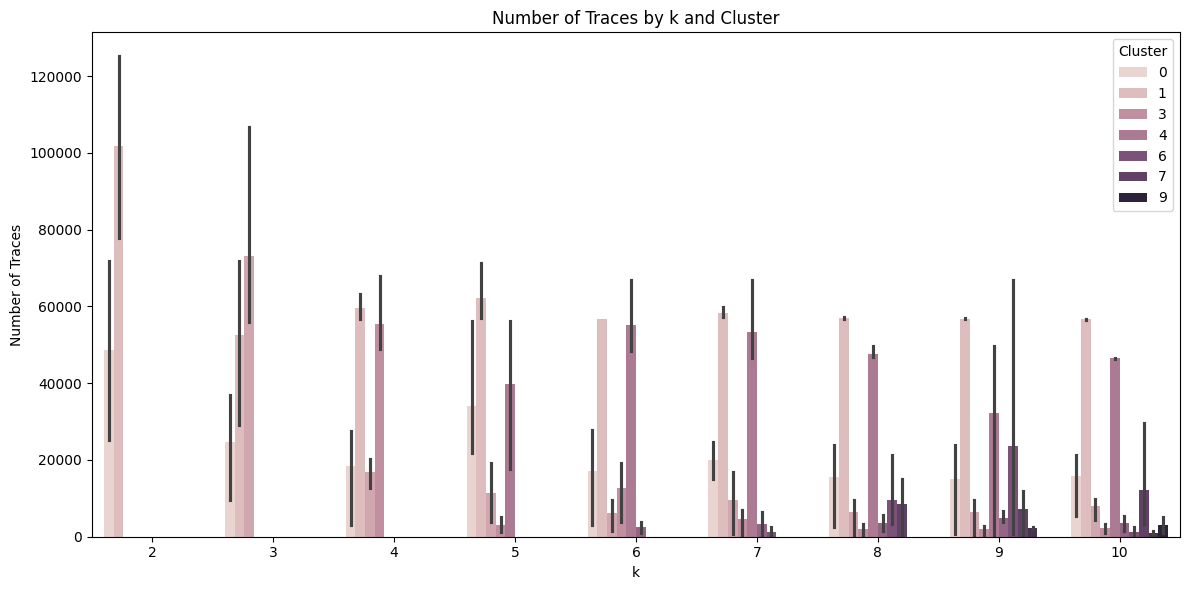

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_counts,
    x='k',
    y='Nb Traces',
    hue='Cluster'
)
plt.title("Number of Traces by k and Cluster")
plt.ylabel("Number of Traces")
plt.xlabel("k")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Entropy

In [8]:
# Entropy from SciPy
result = []
for index, df_ in cluster_counts.groupby(by=["k", "Model", "Conformance"]):
    total_nb_traces = df_["Nb Traces"].sum()
    probabilities = df_["Nb Traces"] / total_nb_traces 
    entropy_value = entropy(probabilities)
    result.append(
        [*index] + [entropy_value]
    )

In [9]:
cluster_entropy = pd.DataFrame(result)
cluster_entropy.columns = ["k", "Model", "Conformance", "Entropy"]
cluster_entropy["max_entropy"] = np.log(cluster_entropy["k"])
cluster_entropy["Scaled Entropy"] = cluster_entropy["Entropy"] / cluster_entropy["max_entropy"]

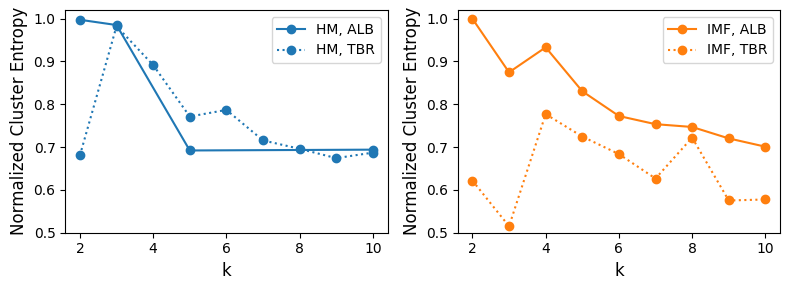

In [11]:
colormap= mpl.colormaps["tab10"]
colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
axes = axes.flatten()

i = 0 
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = cluster_entropy[
            (cluster_entropy["Model"] == model) & (cluster_entropy["Conformance"] == conf)
        ]
        x = df_["k"]
        y = df_["Scaled Entropy"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.legend(loc="upper right")
    ax.set_ylabel("Normalized Cluster Entropy", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    ax.set_ylim([0.5, 1.02])
    i += 1
    # ax.set_yscale("log")

fig.tight_layout()
# fig.savefig(f"{fig_dir}/cluster-entropy.png", dpi=300)

In [12]:
# # Table 1:
# cluster_counts["k"].isin([2, 3, 4,])
# 
# p_table = pd.pivot_table(cluster_counts, index = ["k", "Model", "Conformance", "Cluster"])
# p_table["Nb Traces"] = p_table["Nb Traces"].astype(int)
# table_latex = p_table.to_latex(
#     index=True,  # To not include the DataFrame index as a column in the table
#     # caption="Comparison of ML Model Performance Metrics",  # The caption to appear above the table in the LaTeX document
#     # label="tab:model_comparison",  # A label used for referencing the table within the LaTeX document
#     # position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
#     # column_format="lccc",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
#     escape=True,  # Disable escaping LaTeX special characters in the DataFrame
#     # float_format="{:0.2f}".format  # Formats floats to two decimal places
# )
# print()
# print(table_latex)

## Fitness

In [13]:
# TODO mean fitness only

In [14]:
# Mean Fitness Values

mean_fitnesses = []
for k in ks:
    print(k)
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/fitness",
                )
                iterations = os.listdir(p)
                li = iterations[-1]
            except FileNotFoundError:
                # TODO deal with it
                continue

            fitness = pd.read_csv(os.path.join(p, f"{li}/fitness.csv"))
            fitness = fitness.drop(columns="Unnamed: 0")
            ca = pd.read_csv(os.path.join(p[:-7], "ca.csv"))
            cluster_col = ca.columns[-1]
            ca[["case_index", cluster_col]]

            mean = 0 
            std = 0 
            for cluster in range(k):
                mask = ca[cluster_col] == cluster
                stats = fitness[mask][str(cluster)].describe()
                print(stats)
                mean += stats["mean"] * stats["count"]
                std += stats["std"] * stats["count"]


            weighted_std_fitness = std / len(fitness)
            weighted_mean_fitness = mean / len(fitness)
            # select = cluster_counts[
            #     (cluster_counts["k"] == k) & 
            #     (cluster_counts["Model"] == pm) & 
            #     (cluster_counts["Conformance"] == cc) 
            # ]

            # select.reset_index(drop=True)
            # ms = fitness.describe().T[["mean", "std"]]
            # select["Mean Fitness"] = ms["mean"].values
            # select["Std Mean Fitness"] = ms["std"].values
            # weighted_mean_fitness = (select["Mean Fitness"] * select["Nb Traces"]).sum() / select["Nb Traces"].sum()
            # weighted_std_fitness = (select["Std Mean Fitness"] * select["Nb Traces"]).sum() / select["Nb Traces"].sum()
            mean_fitnesses.append((k, pm, cc, weighted_mean_fitness, weighted_std_fitness))
        


2
count    23270.000000
mean         0.862409
std          0.133387
min          0.422222
25%          0.916667
50%          0.916667
75%          0.928571
max          0.966667
Name: 0, dtype: float64
count    127100.000000
mean          0.893756
std           0.131785
min           0.694444
25%           0.728571
50%           1.000000
75%           1.000000
max           1.000000
Name: 1, dtype: float64
count    73369.000000
mean         0.983843
std          0.050923
min          0.666667
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: 0, dtype: float64
count    77001.000000
mean         0.999773
std          0.005505
min          0.800000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: 1, dtype: float64
count    27102.000000
mean         0.998863
std          0.013540
min          0.777778
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: 0, dtype

In [15]:
# TODO
# Retrieve the clsuter assignment (last column)
# create a mask for filtering those traces that belong to the k_c cluster
# filter each fitness columns with the mask, calculate the mean of the fitness per cluster with only those traces belonging to the cluster
# Then: weigh those values with the count of traces


In [16]:
mean_fitnesses = pd.DataFrame(mean_fitnesses, columns=["k", "Model", "Conformance", "Mean Fitness", "Std Mean Fitness"])
mean_fitnesses["Std Percent"] = mean_fitnesses["Std Mean Fitness"] * 100 / mean_fitnesses["Mean Fitness"]
mean_fitnesses = np.round(mean_fitnesses, 2)
mean_fitnesses["Std Error"] = mean_fitnesses["Std Mean Fitness"] /np.sqrt(k)

In [17]:
mean_fitnesses[mean_fitnesses["Model"] != "dfg"]

,k,Model,Conformance,Mean Fitness,Std Mean Fitness,Std Percent,Std Error
0,2,imf,tbr,0.89,0.13,14.85,0.041110
1,2,imf,al,0.99,0.03,2.79,0.009487
2,2,hm,tbr,0.92,0.10,10.92,0.031623
3,2,hm,al,1.00,0.02,2.24,0.006325
4,3,imf,tbr,1.00,0.01,0.58,0.003162
5,3,imf,al,0.99,0.01,1.29,0.003162
6,3,hm,tbr,1.00,0.01,1.21,0.003162
7,3,hm,al,0.99,0.02,2.31,0.006325
8,4,imf,tbr,1.00,0.02,1.66,0.006325
9,4,imf,al,0.99,0.01,1.10,0.003162


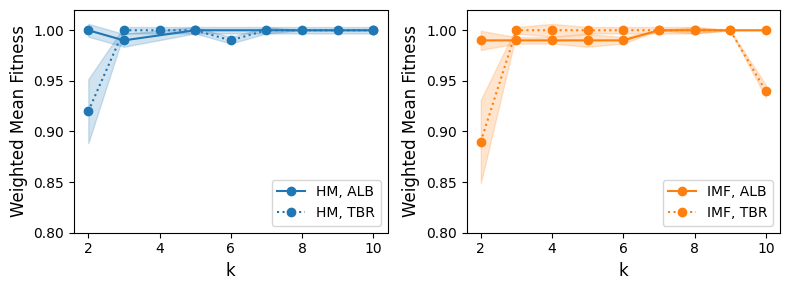

In [18]:
colormap= mpl.colormaps["tab10"]
colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
axes = axes.flatten()

i = 0 
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = mean_fitnesses[
            (mean_fitnesses["Model"] == model) & (mean_fitnesses["Conformance"] == conf)
        ]
        y_err_lower = df_["Mean Fitness"] - df_["Std Error"]
        y_err_upper = df_["Mean Fitness"] + df_["Std Error"]
        y_err = [y_err_lower, y_err_upper]
        
        x = df_["k"]
        y = df_["Mean Fitness"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.fill_between(x, y_err_lower, y_err_upper, color=color, alpha=0.2)
        ax.legend(loc="lower right")
    ax.set_ylabel("Weighted Mean Fitness", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    ax.set_ylim([0.8, 1.02])
    # ax.set_yscale("log")
    i += 1

fig.tight_layout()
# fig.savefig(f"{fig_dir}/mean-fitness.png", dpi=300)

## Execution times

In [19]:
execution_times = []
for k in ks:
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                et = pd.read_csv(os.path.join(p, "execution-times.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue
            et.drop(columns="Unnamed: 0", inplace=True)
            execution_times.append(
                [k, pm, cc ] + list(et.describe().T[["mean", "std"]].values[0])
            )
execution_times = pd.DataFrame(execution_times)

In [20]:
execution_times.columns = columns=["k", "Model", "Conformance", "Mean Execution Time", "Std Mean Execution Time"]

In [21]:
# TODO to latex
execution_times

,k,Model,Conformance,Mean Execution Time,Std Mean Execution Time
0,2,imf,tbr,98.093078,7.431691
1,2,imf,al,97.646880,14.745201
2,2,hm,tbr,102.696012,7.954221
3,2,hm,al,107.868735,6.082731
4,3,imf,tbr,109.230402,7.031558
5,3,imf,al,121.903448,17.537338
6,3,hm,tbr,105.715186,5.532413
7,3,hm,al,125.431598,3.648173
8,4,imf,tbr,119.988276,6.299322
9,4,imf,al,135.220206,13.912812


## Convergence after X Iterations


In [22]:
n_iter = []
for pm in pms:
    for cc in ccs:
        for k in ks:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/models",
                )
                iterations = os.listdir(p)
                ni = len(iterations)
            except FileNotFoundError:
                ni = np.nan
            n_iter.append(
                [k, pm, cc, ni]
            )



In [23]:
n_iter = pd.DataFrame(n_iter)
n_iter.columns = ["k", "Model", "Conformance", "Nb Iterations"]

In [24]:
n_iter

,k,Model,Conformance,Nb Iterations
0,2,imf,tbr,101.0
1,3,imf,tbr,101.0
2,4,imf,tbr,101.0
3,5,imf,tbr,101.0
4,6,imf,tbr,101.0
5,7,imf,tbr,101.0
6,8,imf,tbr,101.0
7,9,imf,tbr,101.0
8,10,imf,tbr,88.0
9,2,imf,al,3.0


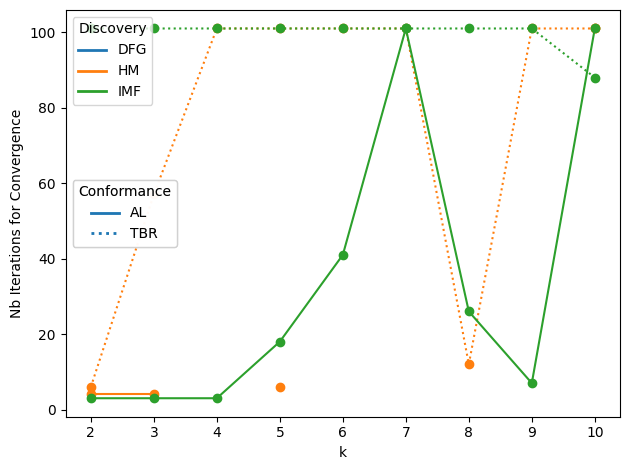

In [25]:
colormap = mpl.colormaps["tab10"]
colors = {
    "dfg": colormap(0),
    "hm": colormap(1),
    "imf": colormap(2),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

color_legend_elements = [
    mpl.lines.Line2D([0], [0], color=color, lw=2, label=model.upper())
    for model, color in colors.items()
]
# Create custom legend for linestyle (Scenario)
linestyle_legend_elements = [
    mpl.lines.Line2D([0], [0], color=colormap(0), lw=2, linestyle=style, label=conformance.upper())
    for conformance, style in linestyles.items()
]


fig, ax = plt.subplots()
for model in colors.keys():
    for conf in linestyles.keys():
        df_ = n_iter[
            (n_iter["Model"] == model) & (n_iter["Conformance"] == conf)
        ]
        
        x = df_["k"]
        y = df_["Nb Iterations"]
        ls = linestyles[conf]
        color = colors[model]
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=f"Discovery {model.upper()}, Conformance {conf.upper()}")
ax.set_ylabel("Nb Iterations for Convergence")
ax.set_xlabel("k")

first_legend = plt.legend(handles=color_legend_elements, title='Discovery', loc='upper left')
second_legend = plt.legend(handles=linestyle_legend_elements, title='Conformance', loc='center left')
plt.gca().add_artist(first_legend)
plt.gca().add_artist(second_legend)


fig.tight_layout()
# fig.savefig("figures/convergence.png", dpi=300)


NameError: name 'f' is not defined

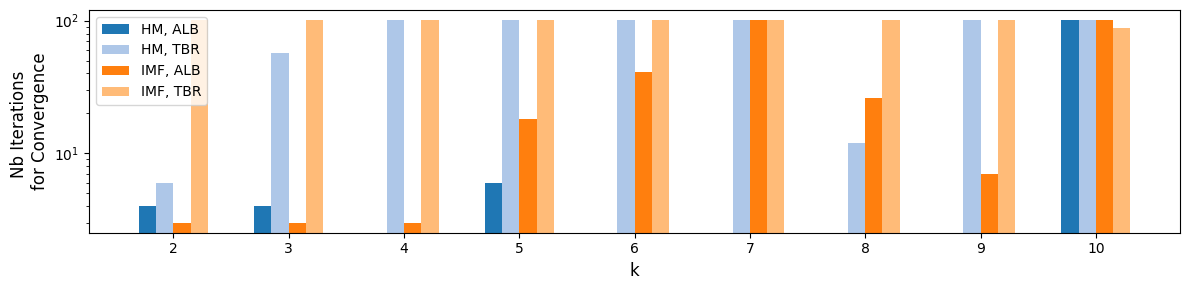

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,3))

colormap = mpl.colormaps["tab20"]

colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

models = list(colors.keys())
confs = list(linestyles.keys())
width = 0.15  # Width of each bar
n_groups = len(models) * len(confs)

unique_ks = sorted(n_iter["k"].unique())
x_indices = np.arange(len(unique_ks))

offset_idx = 0
for model in models:
    for conf in confs:
        df_ = n_iter[
            (n_iter["Model"] == model) & (n_iter["Conformance"] == conf)
        ]
        # Ensure the data is aligned with sorted ks
        y = [df_[df_["k"] == k]["Nb Iterations"].values[0] if k in df_["k"].values else 0 for k in unique_ks]
        offset = (offset_idx - n_groups / 2) * width + width / 2
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"

        ax.bar(x_indices + offset, y, width=width,
               #color=colors[model], 
               color=colormap(offset_idx),
               label=label)
        offset_idx += 1

ax.set_yscale("log")
ax.set_ylabel("Nb Iterations \nfor Convergence", fontdict={"size": 12})
ax.set_xlabel("k", fontdict={"size": 12})
ax.set_xticks(x_indices)
ax.set_xticklabels(unique_ks)
ax.legend()
plt.tight_layout()
f# ig.savefig(f"{fig_dir}/convergence.png", dpi=300)


In [ ]:
# TODO improve the plot below

In [ ]:
ds = "road_traffic"

i = 0
fig, ax = plt.subplots(figsize=(10, 5))
cmap = mpl.colormaps["tab10"]
for pm in pms:
    for cc in ccs:
        n_iterations = []
        for k in ks:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/models",
                )
                iterations = os.listdir(p)
                ni = len(iterations)
            except FileNotFoundError:
                ni = np.nan
            n_iterations.append(ni)

        color = cmap(i)
        ax.plot(ks, n_iterations, color=color, marker="x", label=f"{pm}-{cc}")
        i += 1
ax.set_title(f"Iterations for convergence for dataset {ds}")
ax.legend()
ax.set_xlabel("k")
ax.set_ylabel("n_iterations for convergence")
ax.set_yscale("log")
# TODO what to do about no data for hm-al

## Variant distribution of road traffic dataset

6. Variant distribution: how many activities, traces, ... per variant?
- [ ] How many traces per variant
- [ ] How many different activities per trace
- [ ] The for each cluster: what is the min trace length and the max trace length?


Most importantly for each dataset:

- [x] Check how many n_v variants per event log, i.e. how many of them are the largest, i.e. "main variants"
  - n_v is somewhere between 4 and 6?
- [ ] check how many activities per variant?
- [x] For each pm x cc combination the last model and clustering outcome with k = n_v
- [ ] What does each of the clusters show? Are different variants in the same cluster? Are they not?
- [ ] Does the clustering capture the variant structure?
- [ ] Can we identify different paths per clusters? This would help us to claim the clustering works
- [ ] Also inspect for specific k = n_v the model plots, what do they look like?
- [ ] Identify if there are clusterings with a wide span of trace lengths
  - If we can identify clusters that have a large span of min(len(trace)) and max(len(trace)): are those clusters that capture the a-b-b-b-c and a-b-c?
  - Because this is something that one-hot-encoded could not do


In [29]:
import tk_means as tkm

In [30]:
ds = "road_traffic"
log = tkm.data.read_log(
    os.path.abspath(f"./datasets/{ds}.xes")
)
trace_to_variant = tkm.data.get_variants(log)
log = log.merge(trace_to_variant)

/home/nefta/repos/lmu/tk-means/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:11<00:00, 12651.33it/s]


In [31]:
log.head()


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,@@index,@@case_index,variant_id,variant
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,0,0,0,"(Create Fine, Send Fine)"
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,1,0,0,"(Create Fine, Send Fine)"
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,2,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,3,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,4,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."


In [32]:
# TODO finish thi
# Most frequent activities
# Most frequent variants for k selection

In [33]:
variant_count = log.groupby("variant").count()[["amount"]]
select = variant_count.sort_values(by="amount", ascending=False)[:10]
select = select.reset_index()

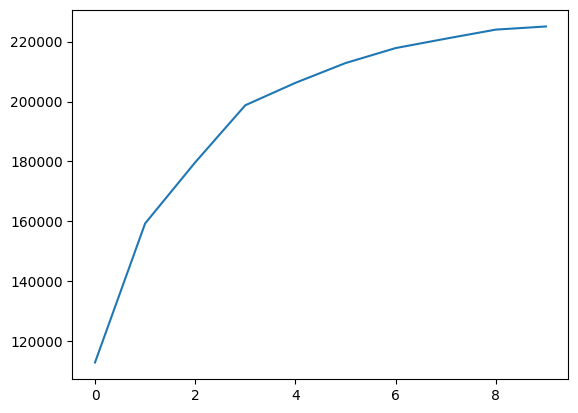

In [34]:
plt.plot(select["amount"].cumsum())

In [35]:
select = select.sort_values(by="amount", ascending=True)
select.reset_index(inplace=True)

Text(0, 0.5, 'Variant')

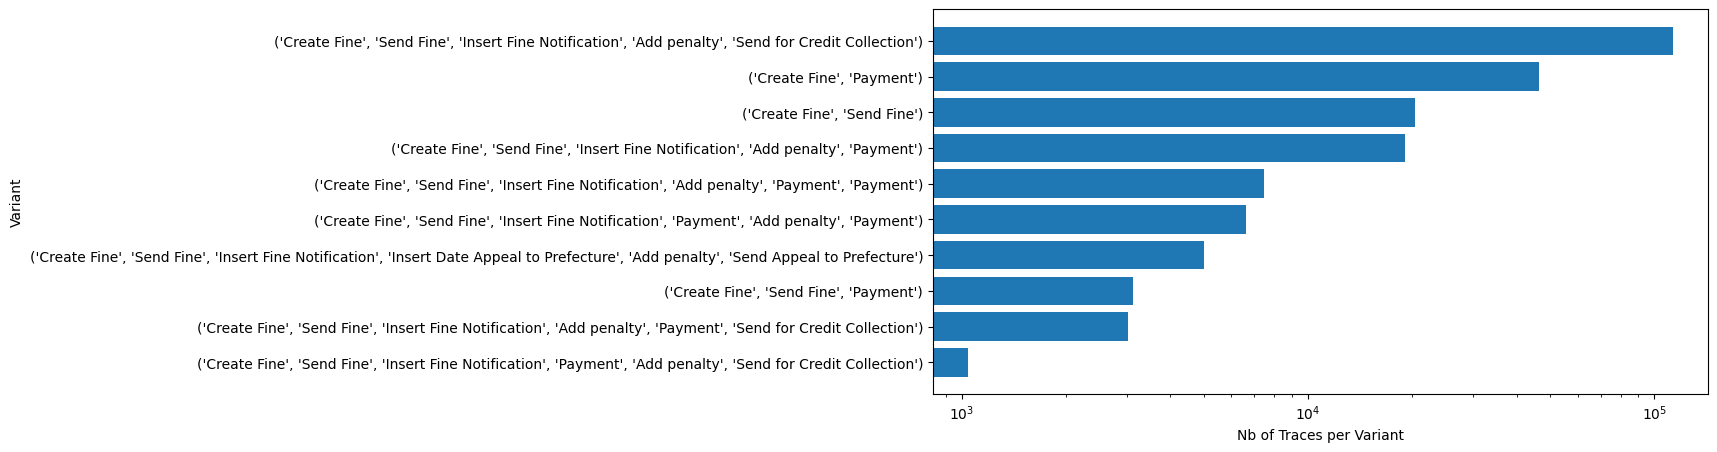

In [36]:
# Most frequent variants
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(select.index, select["amount"].values)
ax.set_yticks(select.index, labels=select["variant"].values)
ax.set_xscale("log")
ax.set_xlabel("Nb of Traces per Variant")
ax.set_ylabel("Variant")

In [37]:
# --> Compare with road traffic somewhere between k  4 - 6

In [88]:
for k in range(4, 7, 1):
    for pm in ["imf"]:
        for cc in ["al"]:
            print(f"Combination {k}, {pm}, {cc}")
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                et = pd.read_csv(os.path.join(p, "execution-times.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue
            ca = pd.read_csv(os.path.join(p, "ca.csv"))
            ca.drop(columns="Unnamed: 0", inplace=True)
            cluster_col = ca.columns[-1]
            ca = ca[["case_index", cluster_col]]
            ca = ca.merge(
                log[["@@case_index", "variant_id", "variant", "concept:name"]],
                left_on="case_index",
                right_on="@@case_index",
            )
            ca.drop(columns="@@case_index", inplace=True)

            activity_count = ca.groupby(by=[cluster_col, "case_index",]).count()["variant_id"]
            activity_count = activity_count.reset_index()
            activity_count.rename(columns={"variant_id": "activity_count"}, inplace=True)
            for c, df_ in activity_count.groupby(cluster_col):
                min_len_act = df_["activity_count"].min()
                max_len_act = df_["activity_count"].max()

                print(f"Cluster {c} length range: {max_len_act - min_len_act}")
                    

Combination 4, imf, al
Cluster 0 length range: 13
Cluster 1 length range: 1
Cluster 2 length range: 17
Cluster 3 length range: 4
Combination 5, imf, al
Cluster 0 length range: 2
Cluster 1 length range: 4
Cluster 2 length range: 16
Cluster 3 length range: 4
Cluster 4 length range: 3
Combination 6, imf, al
Cluster 0 length range: 1
Cluster 1 length range: 2
Cluster 2 length range: 12
Cluster 3 length range: 16
Cluster 4 length range: 3
Cluster 5 length range: 2


In [38]:
k = 4
pm = "imf"
cc = "al"

result = []
p = os.path.join(
    base_dir, 
    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
)

ca = pd.read_csv(os.path.join(p, "ca.csv"))
ca.drop(columns="Unnamed: 0", inplace=True)
cluster_col = ca.columns[-1]
ca = ca[["case_index", cluster_col]]
ca = ca.merge(
log[["@@case_index", "variant_id", "variant", "concept:name"]],
left_on="case_index",
right_on="@@case_index",
)
ca.drop(columns="@@case_index", inplace=True)

activity_count = ca.groupby(by=[cluster_col, "case_index",]).count()["variant_id"]
activity_count = activity_count.reset_index()
activity_count.rename(columns={"variant_id": "activity_count"}, inplace=True)
for c, df_ in activity_count.groupby(cluster_col):
    print(f"Cluster {c}")
    min_len_act = df_["activity_count"].min()
    traces_min = df_[df_["activity_count"] == min_len_act]["case_index"].unique()
    print(f"Traces with minimal length: {traces_min}")
    
    max_len_act = df_["activity_count"].max()
    traces_max = df_[df_["activity_count"] == max_len_act]["case_index"].unique()
    print(f"Traces with maximum length: {traces_max}")
    length_range = max_len_act - min_len_act
    result.append(
        [k, pm, cc, c, traces_min, traces_max, length_range]
    )


length_var = pd.DataFrame(result)
length_var.columns=["k", "imf", "al", "cluster", "traces_min", "traces_max", "length_range"]

Cluster 0
Traces with minimal length: [     0     12     27 ... 150350 150352 150363]
Traces with maximum length: [146927]
Cluster 1
Traces with minimal length: [     1      4      7 ... 150367 150368 150369]
Traces with maximum length: [  3137   3237   4534   4662   6163   9059  11180  14183  16255  17083
  17161  17449  19058  24306  24307  24308  24309  24933  25748  25749
  25791  25945  25990  26199  26285  26624  26693  26910  26957  27062
  27072  27083  27103  27525  27526  27527  27528  27724  27726  27957
  27962  28543  28741  44448  45822  45933  47758  47959  48301  50567
  50799  52047  52112  53799  54717  54725  60055  61627  64463  77751
  78900  79077  79280  79896  80622  80969  81554  81621  83344  83608
  84555  85148  88615  89895  90128  90157  90361  90584  90787  93089
  93778  98115 101660 103840 104471 105392 136967 139122 139313 139451
 141048 141279 141543 141619 144020 145215 145863 146274 146292 146294
 146315 146321 146350 146362 146378 146463 146476 146

In [39]:

# log[log["@@case_index"].isin(cis)]# .variant.unique()

In [62]:
activity_count.groupby(by=[cluster_col, "activity_count"]).count().reset_index().sort_values(by="activity_count")

,cluster_assignment_2,activity_count,case_index
0,0,2,20385
24,3,2,46371
9,2,3,3505
1,0,3,10
10,2,4,225
2,0,4,1
7,1,5,56514
11,2,5,9533
12,2,6,2879
8,1,6,124


In [40]:
all_seen = []
for c in range(k):
    cis = activity_count[activity_count[cluster_col] == c].sort_values(by="activity_count", ascending=False).case_index
    seen = set()
    for ci in cis:
        trace = tuple(log[log["@@case_index"] == ci]["concept:name"].values)
        seen.add(trace)
    print(f"Unique traces for cluster {c}:")
    print(seen)
    all_seen.append(seen)


Unique traces for cluster 0:
{('Create Fine', 'Appeal to Judge', 'Send Fine'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment', 'Payment'), ('Create Fine', 'Send Fine'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Send for Credit Collection'), ('Create Fine', 'Appeal to Judge', 'Send Fine', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Send for Credit Collection'), ('Create Fine', 'Send Fine', 'Appeal to Judge')}
Unique traces for cluster 1:
{('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), ('Cr

In [ ]:
# Cluster 0 captures loops of one or two behaviours, rightfully grouping together process executions of very differnt lengths (repeated Payment)
# Cluster 1 has a more captures process execution that allow for varaition of order
# Cluster 2 Allows for more diverse behaviours including loops and process 
# Cluster 3 contains a lot of small process executions

In [66]:
for k in range(4):
    for trace in all_seen[k]:
        for event in trace:
            if "Send Appeal" in event:
                print(k, trace)

2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture', 'Payment', 'Payment', 'Payment')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture')
2 ('Create Fine', 'Send Fine', 'Payment', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Appeal to Judge', 'Send Appeal to Prefecture', 'Add penalty', 'Receive Result Appeal from Prefecture')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Add penalty', 'Receive Result Appeal from Prefecture', 'Notify Result Appeal to Offender', 'Payment', 'Appeal to Judge')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Insert Date Appeal to

In [ ]:
# Cluster 0 captures loops:
# max ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Send for Credit Collection']
# "middle" payment
# min ['Create Fine', 'Send Fine']

# Cluster 1 captures variations:
# min: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection']
# max: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Appeal to Judge', 'Add penalty', 'Send for Credit Collection']
# variation of max: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Appeal to Judge', 'Send for Credit Collection']

# Cluster 2 captures repeated pattern:
# max: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Appeal to Judge', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment']
# min: ['Create Fine', 'Send Fine', 'Payment']
# and Variation of min: ['Create Fine', 'Payment', 'Send Fine']

# Cluster 3
# min: ['Create Fine', 'Payment']
# max: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture']

In [121]:
#Cluster 0 and 2

ca

,case_index,cluster_assignment_2,variant_id,variant,concept:name
0,0,0,0,"(Create Fine, Send Fine)",Create Fine
1,0,0,0,"(Create Fine, Send Fine)",Send Fine
2,1,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Create Fine
3,1,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Send Fine
4,1,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Insert Fine Notification
...,...,...,...,...,...
561465,150369,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Create Fine
561466,150369,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Send Fine
561467,150369,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Insert Fine Notification
561468,150369,1,1,"(Create Fine, Send Fine, Insert Fine Notificat...",Add penalty


In [ ]:
# Each variant is in exactly one cluster
len(ca.groupby(by=["variant_id", cluster_col]).count()) == len(ca["variant_id"].unique())

In [ ]:
# clusters that have a large span of min(len(trace)) and max(len(trace)): are those clusters that capture the a-b-b-b-c and a-b-c?

In [ ]:
ca.groupby(by=[cluster_col, "case_index"]).count().reset_index()

In [ ]:
# for each trace in a cluster: get the min(len(trace)) and the max(len(trace))
# len(trace) == nb of activities in a case?

ca[cluster_col].unique()

In [ ]:

# - [ ] Identify if there are clusterings with a wide span of trace lengths
#   - If we can identify clusters that have a large span of min(len(trace)) and max(len(trace)): are those clusters that capture the a-b-b-b-c and a-b-c?
#   - Because this is something that one-hot-encoded could not do
# 

### Fitness over Iterations

## Precision of final models

In [42]:
import pm4py

In [87]:
# # Ca 15 min
# precision_results = []
# for pm in pms:
#     for cc in ccs:
#         for k in ks:
#             try:
#                 p = os.path.join(
#                     base_dir, 
#                     f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/models",
#                 )
#                 iterations = os.listdir(p)
#                 iteration_dir = iterations[-1]
#             except FileNotFoundError:
#                 continue
#             model_dir = os.path.join(p, iteration_dir)
#             model_file = [f for f in os.listdir(model_dir) if "pnml" in f][-1]
#             model_file_path = os.path.join(model_dir, model_file)
#             net, im, fm = pm4py.read_pnml(model_file_path)
#             precision = pm4py.algo.evaluation.precision.algorithm.apply(log,net,im,fm)
#             precision_results.append(
#                 [k, pm, cc, precision]
#             )
# 
# precisions = pd.DataFrame(precision_results, columns=["Model", "Conformance", "k", "Precision"])

In [ ]:
# precisions.to_csv("precision.csv", index=False)

In [27]:
precisions = pd.read_csv("precision.csv")
precisions.columns = ["k", "Model", "Conformance", "Precision"]

In [28]:
precisions

,k,Model,Conformance,Precision
0,2,imf,tbr,0.613803
1,3,imf,tbr,0.712737
2,4,imf,tbr,0.763258
3,5,imf,tbr,0.999967
4,6,imf,tbr,0.599478
5,7,imf,tbr,0.851669
6,8,imf,tbr,0.868608
7,9,imf,tbr,0.999453
8,10,imf,tbr,0.990854
9,2,imf,al,0.736302


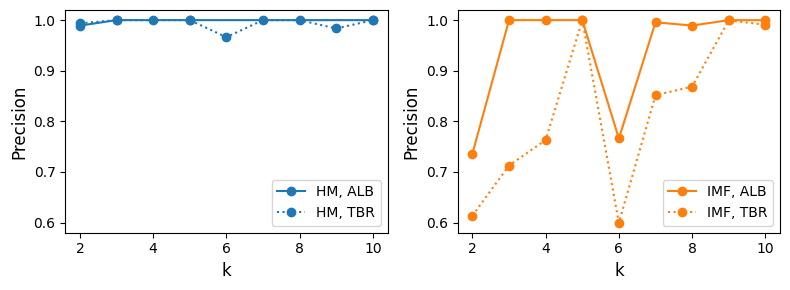

In [31]:
colormap = mpl.colormaps["tab10"]
colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

color_legend_elements = [
    mpl.lines.Line2D([0], [0], color=color, lw=2, label=model.upper())
    for model, color in colors.items()
]
# Create custom legend for linestyle (Scenario)
linestyle_legend_elements = [
    mpl.lines.Line2D([0], [0], color=colormap(0), lw=2, linestyle=style, label=conformance.upper())
    for conformance, style in linestyles.items()
]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes = axes.flatten()

i = 0
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = precisions[
            (precisions["Model"] == model) & (precisions["Conformance"] == conf)
        ]
        x = df_["k"]
        y = df_["Precision"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.legend(loc="lower right")
    ax.set_ylabel("Precision", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    # ax.set_yscale("log")
    ax.set_ylim([0.58, 1.02])
    i += 1
 


# first_legend = plt.legend(handles=color_legend_elements, title='Discovery', loc='center right')
# second_legend = plt.legend(handles=linestyle_legend_elements, title='Conformance', loc='lower right')
# plt.gca().add_artist(first_legend)
# plt.gca().add_artist(second_legend)


fig.tight_layout()
fig.savefig(f"{fig_dir}/precision.png", dpi=300)

## Scratch

In [ ]:
all_stats = []
columns = ["ds", "pm", "cc", "k", "max_iterations"]
for path, param in zip(paths, parameters):
    stats = pd.DataFrame(data=list(param)).T 
    stats.columns = columns
    param_col = "-".join([str(p) for p in param])
    stats["param_col"] = param_col

    try:
        exec_time = pd.read_csv(
            os.path.join(path, "execution-times.csv"),
            index_col=0,
        )
    except FileNotFoundError:
        # No sound model created
        stats["execution-times-seconds"] = np.nan
        all_stats.append(stats)
        continue
    stats = stats.loc[stats.index.repeat(len(exec_time))]
    stats.reset_index(drop=True, inplace=True)
    stats["execution-times-seconds"] = exec_time["execution-times-seconds"]
    all_stats.append(stats)

In [ ]:
execution_times = pd.concat(all_stats)
execution_times.reset_index(drop=True, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(
    x='param_col',
    y='execution-times-seconds',
    data=execution_times,
    ax=ax
    )
tl = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


### Cluster Assignment

In [ ]:
# adjusted rand score?
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
# use final cluster assignment of each k
# For each pm x cc combination, plot the rand score?

In [ ]:
len(pms) * len(ccs) * len(ks) * max_iterations * 2

In [ ]:
pm = "dfg"
cc = "al"

In [ ]:
def get_clusterings(ds, pm, cc,):
    clusterings_k = {}
    no_data_for = []
    for k in ks:
        p = os.path.join(
            base_dir, 
            f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
        )
        try:
            ca = pd.read_csv(
                os.path.join(p, "ca.csv"),
                index_col=0,
            )
            cluster_labels = ca[ca.columns[-1]].values
        except FileNotFoundError:
            # No data for those params
            cluster_labels = np.ones(len(ca)) * -1
            no_data_for.append(k)
        clusterings_k[k] = cluster_labels
    # TODO no data for?
    return clusterings_k
    

In [ ]:
def plot_cluster_stability(clusterings_k, ks):
    ari_matrix = np.zeros((len(ks), len(ks)))
    for i, k1 in enumerate(ks):
        for j, k2 in enumerate(ks):
            ari_matrix[i, j] = adjusted_rand_score(clusterings_k[k1], clusterings_k[k2])

    # TODO plot no data for differently!

    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(ari_matrix, cmap='viridis', )# interpolation='nearest')
    plt.colorbar(im, label="Adjusted Rand Index (ARI)")


    ax.set_xticks(np.arange(len(ks)), ks)
    ax.set_yticks(np.arange(len(ks)), ks)
    ax.set_xlabel("k")
    ax.set_ylabel("k")
    ax.set_title(f"Cluster stability for dataset {ds}, model {pm}, conformance check {cc}")

#### Cluster Stability

In [ ]:
ds = "road_traffic"
pms = "imf", "hm", "dfg"
ccs = "tbr", "al"

for pm in pms:
    for cc in ccs:
        clusterings = get_clusterings(ds, pm, cc)
        plot_cluster_stability(clusterings, ks)

#### Cluster Size, i.e. traces per cluster

In [ ]:
for pm in pms:
    for cc in ccs:
        clusterings = get_clusterings(ds, pm, cc)
        break
    break

In [ ]:
# For each pm x cc
pd.DataFrame(clusterings)#.value_counts()